### Makemore Part 3: MLP with Optimizations

#### Optimize Initial Loss

https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=259s

A naive way to initialize a network is to randomly assign the probability of one character
following another. This can lead to a high initial loss and then once the network starts to
train there will be a dramatic drop.

A better way to do this intiialization would be to assign the probabilty of one character
following another would be to assign them all a uniform likelihood. For instance, for our 27
characters, each character will start off with a 1/27 probability.

The effect this has on the neural network is that the network spends more time optimizing the
network rather than squashing the weights down to a point at which loss optimization can begin

#### Fixing Saturated `tanh`

https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=779s

To understand that we have a saturated `tanh`, meaning the hidden layer is saturated, we can
plot the histogram of hidden layer activation values that represent the hidden layer.

```python
h_pre_activations = embeddings @ W1 + b1 # hidden layer
h = torch.tanh(h_pre_activations) # activation of hidden layer
```

![Histogram of Hidden Layer Values](images/saturated_tanh_hidden_layer_histogram.png)

To the beginner this histogram doesn't carry much meaning. To an experience engineer or researcher
this histogram presents a problem for the training of the network. 

The behavior of `tanh(x)` is a squeezing function that brings value between `-1` and `1`. 

![tanh function graph](images/tanh_function.png)

This might seem fine but if we look at the implementation of the backward pass of `tanh`, we can 
see that the derivative of `tanh(x)` is `1 - tanh(x)^2`. Therefore, the derivative of `tanh(x)` is
very small when `tanh(x)` is close to `1` or `-1`. So when the gradient update happens,
`self.grad += (1 - t**2) * out.grad`, the gradient effectively vanishes when values are close to
`1` or `-1`. The closer the derivative value of `tanh(x)` is to `0`, the gradient will effectively
pass through to the next layer of the network. So the change in the gradient is proportional to
change that occurs at `(1 - t**2)`.

To visualize how many nuerons are saturated, we can look at the graph that depicts how many neurons
have a value that will make the gradient vanish, values close to `-1` or `1`, and how many values
will make some proportion of the gradient continue to propagate. In the image, the amount of white
shows what proportion of values will make the gradient vanish.

![Hidden Layer Activation Values Boolean Tensor Graph](images/hidden_layer_activation_values_boolean_tensor.png)

Something to look for in graphs like this, is a single column that is all white. This is called a
"dead neuron" meaning that the gradient will never propagate through the neuron and the neuron
will never enter the activation area of the `tanh` function.

This behavior of `tanh` is not unique amongst activation functions. Other activation functions
such as `sigmoid`, `leaky ReLU`, `Maxout`, `ReLU` and `ELU` can have the same dangers due to
their function behavior. This can be seen by looking at their graphs.

After introducing some entropy to the initialization of the network, we can see that the network
is able to better produce neurons that will activate the `tanh` function.

```python
# Entropy introduced on the initialization of the network
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden,),                     generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn((vocab_size,),                   generator=g) * 0
```

![Hidden Layer Activation Values Boolean Tensor With Entropy](images/hidden_layer_activation_values_boolean_tensor_updated.png)

This will positively impact the performance of the network.

### Calculating The Initial Scale: "Kaiming Init"

The paper [Delving Deep into Rectifiers: Surpassing Human-level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)
is a good resource for learning about initializing neural networks. The
paper studies other activation functions but it is a good analysis
of how to reason about initialization.

[PyTorch `torch.nn.init.kaiming_normal`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

### Batch Normailzation

Batch Normalization is a modern innovation that makes the initiailization
techniques of neural networks not as important as they were before. Batch 
Norm enabled the training of deep neural networks reliably and it "just"
worked.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Rethinking "Batch" in BatchNorm](https://arxiv.org/abs/2105.07576)

The insight from batch normalization is that we want the hidden states, hidden layer pre-activation values, to be guassian at
initialization. This will ensure that the network doesn't experience saturated hidden layers. So to do this, you just normalize
the hidden states to be guassian. This may seem like a crazy thing however because batch normalization is a differentiable operation
this means that we can backpropagate through it, returning the idea to sanity.

From the paper, *Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*, algorithm 1 
(batch normalization) shows how the hidden layer pre-activations can normalized and then scaled & shifted. The scaling and shifting
is necessary to allow backpropagation to stear the normalization so that the network can still learn.

Batch normalization also introduces a regularizing effect on the logits of the network due to residual entropy introduced by the 
normalization of previously seen batches of inputs.

For it's time, batch normalization worked really well. Researchers are trying to remove this batch normalization and insert other
normalization techniques such as *layer normalization*, *group normalization*, *weight normalization*, *spectral normalization* and
*self-normalizing neural networks*.

To summarize, batch normalization is used to control the statistics of activations in the neural network. Batch norm layers can be
scattered throughout a neural network but are typically placed after layers of multiplication (e.g., linear layer or convolutional
layer). Batch norm has two parameters, gain and bias, which are trained during back propagation, additionally batch norm has two
buffers, mean and standard deviation, which are not trained but are computed during training in a running update fashion (there
are techniques for this but the code below uses a simple one for simplicity). The running mean and standard deviation are used
later at inference so they don't have to be re-calculated after training.

#### Batch Normalization Bias

Because batch normalization has it's own bias, the use of a bias on the layer you are normalizing is subtracted out therefore it can be removed. In the case of the code below, `b1` is not necessary

In [139]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [140]:
# read in all words
words = open('names.txt', 'r').read().splitlines()

In [144]:
len(words)

32033

In [141]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
block_size = 3 # context length: how many characters do we take to predict the next one?
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [150]:
# build the dataset
def build_dataset(words):
  X, Y = [], [] # inputs, labels
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append (rolling window of context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80%
X_val, Y_val = build_dataset(words[n1:n2]) # 10%
X_test, Y_test = build_dataset(words[n2:]) # 10%

torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [151]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size) ** 0.5))
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn((vocab_size,),                   generator=g) * 0

# BatchNorm parameters
batch_norm_gain = torch.ones((1, n_hidden))
batch_norm_bias = torch.zeros((1, n_hidden))
batch_norm_mean_running = torch.zeros((1, n_hidden))
batch_norm_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, batch_norm_gain, batch_norm_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [152]:
# optimzation
max_steps = 200000
batch_size = 32
losses = []
steps = []
for i in range(max_steps):
    # ---- Mini-batch Construction ----
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X, Y
    
    # ---- Forward Pass ----
    emb = C[Xb] # embeded the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # ++++ Linear Layer ++++
    h_pre_activations = emb_cat @ W1 # hidden layer pre-activation
    # ++++ Batch Norm Layer ++++
    batch_norm_mean_i = h_pre_activations.mean(0, keepdim=True)
    batch_norm_std_i = h_pre_activations.std(0, keepdim=True)
    h_pre_activations = batch_norm_gain * (h_pre_activations - batch_norm_mean_i) / batch_norm_std_i + batch_norm_bias
    with torch.no_grad():
        # Use torch.no_grad() here to put this outside of the gradient based optimization
        #
        # Update the running batch norm values to be mostly what they used to be last batch
        # with a slight nudge in the direction of the current batch
        batch_norm_mean_running = 0.999 * batch_norm_mean_running + 0.001 * batch_norm_mean_i
        batch_norm_std_running = 0.999 * batch_norm_std_running + 0.001 * batch_norm_std_i
    # ++++ Non-Linearity ++++
    h = torch.tanh(h_pre_activations) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # ---- Backward Pass ----
    for p in parameters:
        p.grad = None
    loss.backward()

    # ---- Parameter Update ----
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # ---- Track Statistics ----
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    steps.append(i)

      0/ 200000: 3.2788
  10000/ 200000: 2.1573
  20000/ 200000: 2.3661
  30000/ 200000: 2.1708
  40000/ 200000: 2.2585
  50000/ 200000: 2.7153
  60000/ 200000: 2.0828
  70000/ 200000: 2.3331
  80000/ 200000: 2.3124
  90000/ 200000: 1.9479
 100000/ 200000: 1.8613
 110000/ 200000: 1.7870
 120000/ 200000: 2.3108
 130000/ 200000: 1.9558
 140000/ 200000: 2.4277
 150000/ 200000: 2.0879
 160000/ 200000: 2.0539
 170000/ 200000: 2.3074
 180000/ 200000: 1.8473
 190000/ 200000: 2.1584


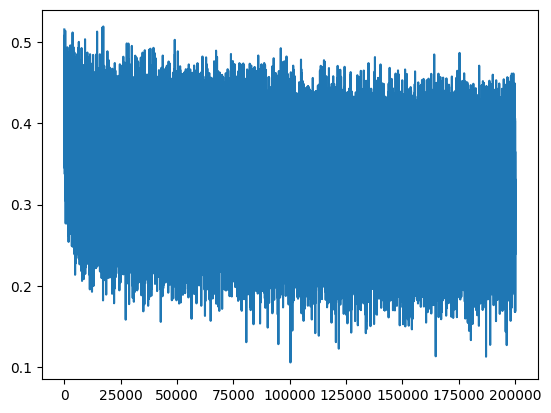

In [153]:
plt.plot(losses)

In [155]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    # setup
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]

    # forward pass
    emb = C[x] # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size, n_embd)
    h_pre_activations = emb_cat @ W1 # (N, block_size, hidden_size)
    # h_pre_activations = batch_norm_gain * (h_pre_activations - h_pre_activations.mean(0, keepdim=True)) / h_pre_activations.std(0, keepdim=True) + batch_norm_bias
    h_pre_activations = batch_norm_gain * (h_pre_activations - batch_norm_mean_running) / batch_norm_std_running + batch_norm_bias
    h = torch.tanh(h_pre_activations) # (N, hidden_size)
    logits = h @ W2 + b2 # (N, vocab_size)

    # eval
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066537618637085
val 2.1117324829101562


### Torchifying Our Neural Network

Below are some "modules" that are similar to ones in PyTorch so that our model can be constructed similarly to how it
would be done in PyTorch

In [156]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [157]:
class BatchNorm1D:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True)   # batch var
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [158]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

In [175]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


47551


In [185]:
# optimzation
max_steps = 200000
batch_size = 32
losses = []
updates = []
for i in range(max_steps):
  # ---- Mini-batch Construction ----
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X, Y
  # ---- Forward Pass ----
  emb = C[Xb] # embed characters into vector
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # compute loss
  # ---- Backward Pass ----
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # ---- Optimization Step ----
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # SGD update

  # ---- Track Progress ----
  if i % 10_000 == 0:
    print(f"Step {i:7d}/{max_steps:7d}: Loss = {loss.item():.4f}")
  
  losses.append(loss.log10().item())
  with torch.no_grad():
    updates.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: take out to run full optimization


Step       0/ 200000: Loss = 3.2983


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.34%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 1.88%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.38%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.03%
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 2.12%


Text(0.5, 1.0, 'Activation Distribution')

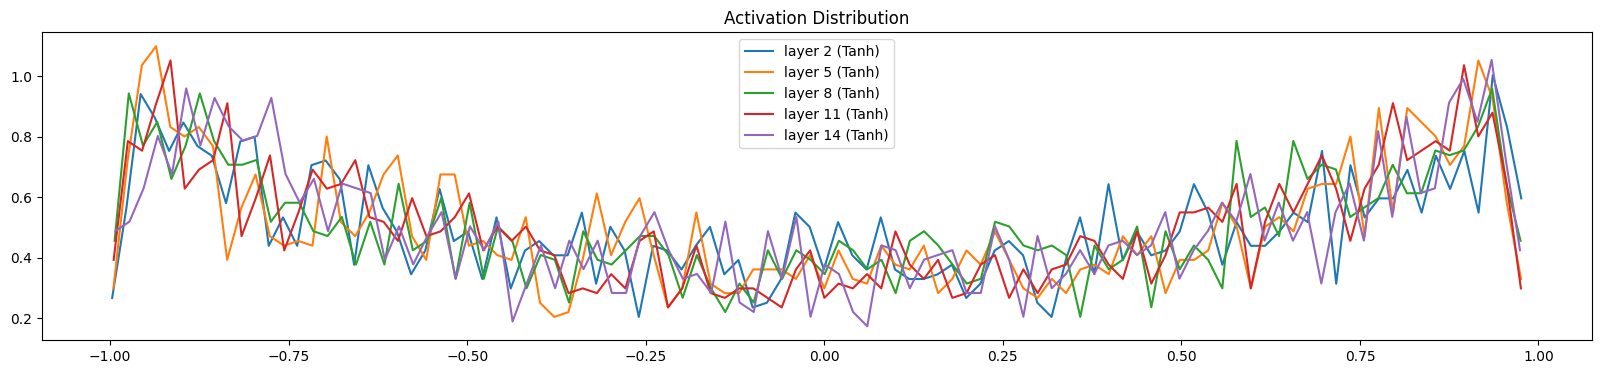

In [186]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')



layer 2 (      Tanh): mean +0.000000, std 3.301930e-03
layer 5 (      Tanh): mean -0.000000, std 2.926855e-03
layer 8 (      Tanh): mean -0.000000, std 2.671884e-03
layer 11 (      Tanh): mean -0.000000, std 2.453351e-03
layer 14 (      Tanh): mean -0.000000, std 2.426417e-03


Text(0.5, 1.0, 'gradient distribution')

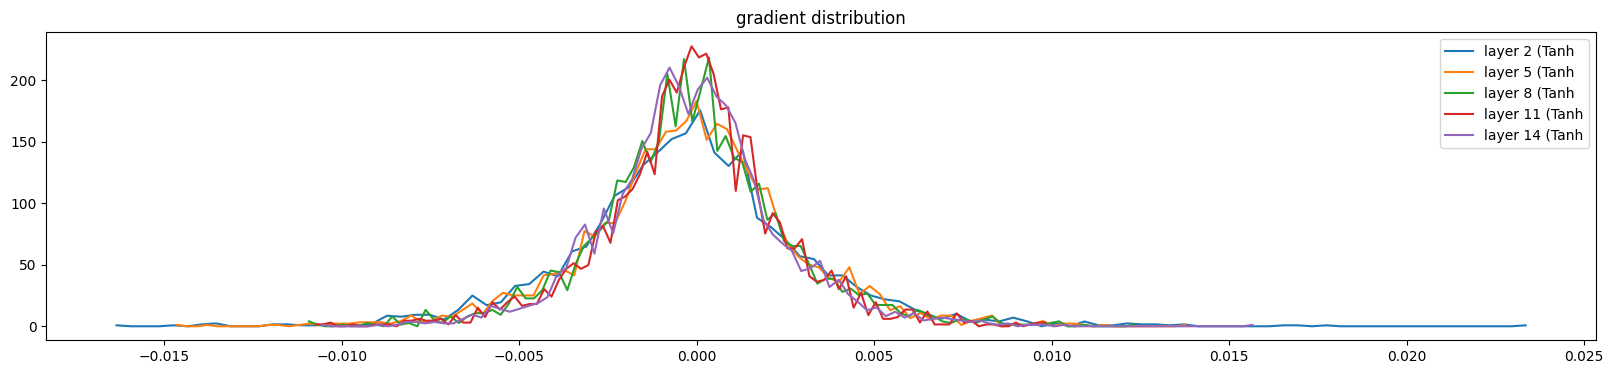

In [187]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.454953e-03 | grad:data ratio 9.445071e-03
weight  (30, 100) | mean +0.000087 | std 7.202108e-03 | grad:data ratio 2.303769e-02
weight (100, 100) | mean -0.000036 | std 6.208931e-03 | grad:data ratio 3.712489e-02
weight (100, 100) | mean +0.000083 | std 5.654251e-03 | grad:data ratio 3.351878e-02
weight (100, 100) | mean +0.000003 | std 5.164833e-03 | grad:data ratio 3.077069e-02
weight (100, 100) | mean -0.000015 | std 5.040820e-03 | grad:data ratio 3.002375e-02
weight  (100, 27) | mean -0.000020 | std 1.014399e-02 | grad:data ratio 6.084019e-02


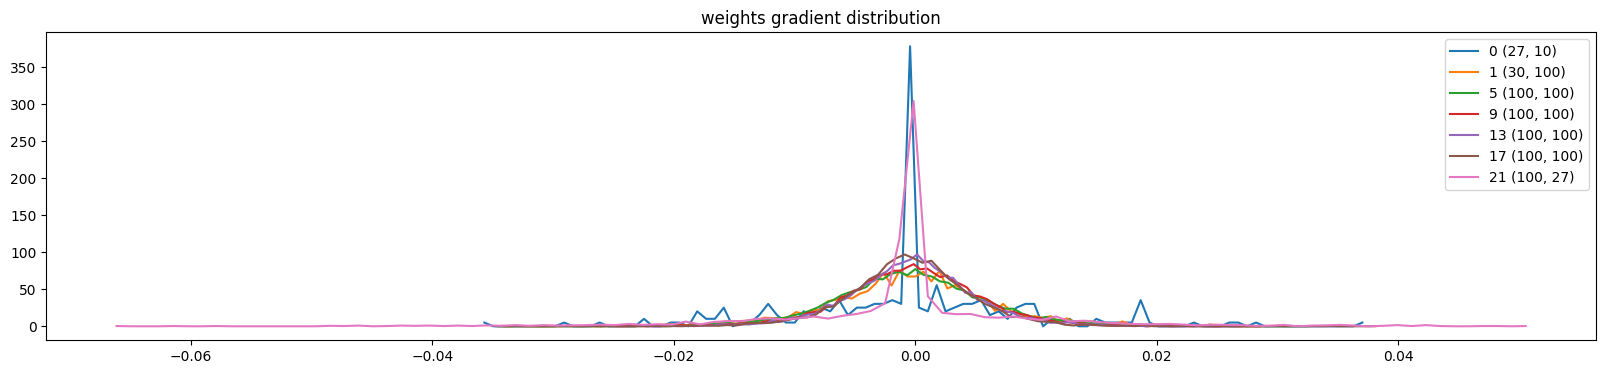

In [188]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

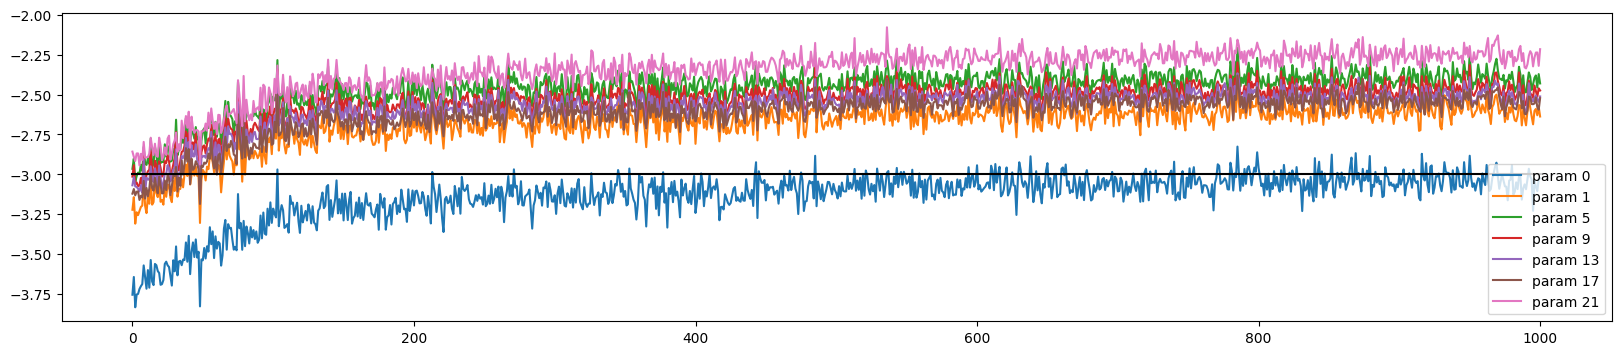

In [189]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([updates[j][i] for j in range(len(updates))])
    legends.append('param %d' % i)
plt.plot([0, len(updates)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);